# `CLOUD.jl` - 2D linear advection example

In [1]:
using OrdinaryDiffEq
using CLOUD;

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1423
[ Info: Installing pyqt package to avoid buggy tkagg backend.
┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/XaELc/src/init.jl:165


Define the physical problem

In [2]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ)))) # end time for one period

initial_data = InitialDataSine(A,k)
conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)));

Set discretization parameters

In [3]:
M = 4
p = 4
p_map = 4
form = WeakConservationForm(StandardMapping(),LaxFriedrichsNumericalFlux())
strategy = Lazy()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.1*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*10));

Set up a `DGSEM` scheme with LG quadrature on quadrilaterals of degree `p` with `M` edges in each direction

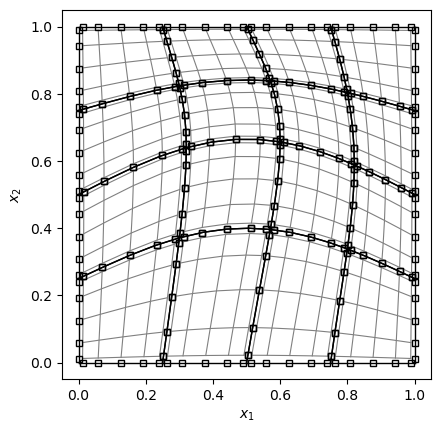

In [4]:
reference_approximation =ReferenceApproximation(
    DGSEM(p), Quad(),
    volume_quadrature_rule=LGQuadrature(),
    facet_quadrature_rule=LGQuadrature(),
    mapping_degree=p_map, N_plot=50)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.1)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_2d_dgsem/", overwrite=true, clear=true)

visualize(spatial_discretization, results_path, "mesh.pdf", 
    plot_volume_nodes=false, grid_lines=true)

Run the solver and plot the solution

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            426ms / 483.2%          57.4MiB / 1827.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 eval residual          40.8k    1.19s   57.9%  29.2μs    511MiB   48.7%  12.8KiB
   facet terms          40.8k    541ms   26.3%  13.3μs    224MiB   21.3%  5.61KiB
   volume terms         40.8k    474ms   23.0%  11.6μs    224MiB   21.4%  5.62KiB
   mass matrix solve    40.8k   45.2ms    2.2%  1.11μs   19.9MiB    1.9%     512B
 extrapolate solution   40.8k    565ms   27.5%  13.9μs    198MiB   18.9%  4.97KiB
 eval flux              40.8k    150ms    7.3%  3.68μs   79.3MiB    7.6%  1.99KiB
 gather externa

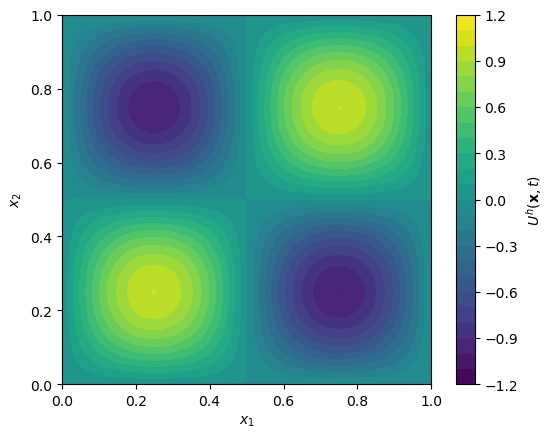

In [5]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)

CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")
plotter = Plotter(spatial_discretization, results_path)
visualize(last(sol.u), plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25,
    label="U^h(\\mathbf{x},t)")


Plot the exact solution (same as initial data)

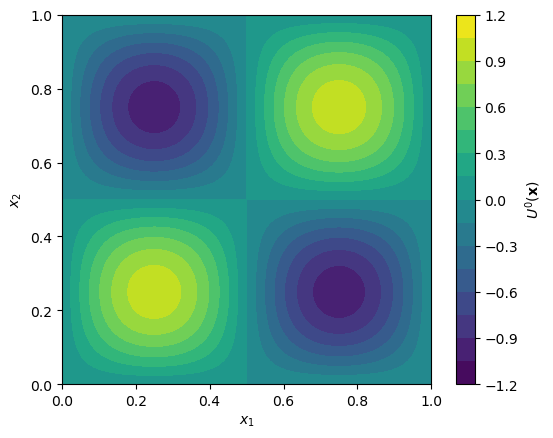

In [6]:
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=17, label="U^0(\\mathbf{x})")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [7]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
0.00068216127441316
Conservation (initial/final/diff):
[-1.108594540819019e-8][-1.1085946192285201e-8][-7.840950111415168e-16]
Energy (initial/final/diff):
[0.12499998811286066][0.12497973419588697][-2.025391697368928e-5]


Set up a `DGMulti` scheme on triangles of degree `p` with `M` edges in each direction

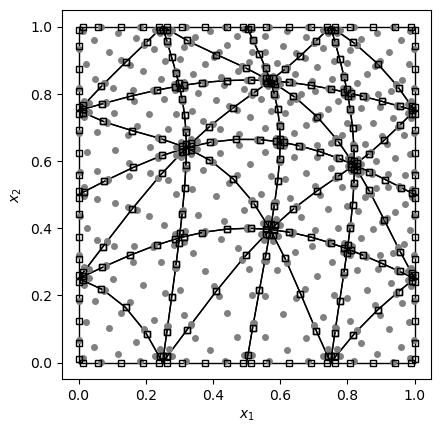

In [8]:
reference_approximation = ReferenceApproximation(
    DGMulti(p), Tri(), mapping_degree=p_map, N_plot=10)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.1)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_2d_dgmulti/", overwrite=true, clear=true)

visualize(spatial_discretization, results_path, "mesh.pdf", 
    plot_volume_nodes=true, grid_lines=false)

Run the solver and plot the solution

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:          127μs / 1082336.7%       11.9KiB / 9714215.6%  

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 eval residual          81.6k    779ms   56.5%  9.54μs    471MiB   41.8%  5.91KiB
   volume terms         81.6k    314ms   22.8%  3.85μs    212MiB   18.8%  2.66KiB
   mass matrix solve    81.6k    229ms   16.6%  2.81μs    186MiB   16.5%  2.33KiB
   facet terms          81.6k    130ms    9.4%  1.59μs   25.3MiB    2.2%     325B
 gather external state  81.6k    153ms   11.1%  1.87μs    350MiB   31.1%  4.39KiB
 eval flux              81.6k    145ms   10.5%  1.77μs   69.8MiB    6.2%     896B
 eval numerical

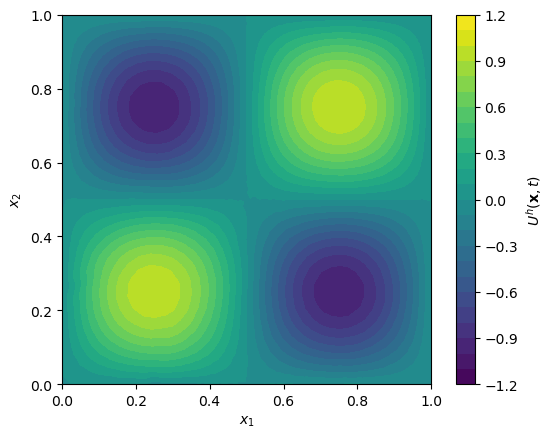

In [9]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)

CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")

plotter = Plotter(spatial_discretization, results_path)
visualize(last(sol.u), plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25,
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [10]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
0.0034594895345242908
Conservation (initial/final/diff):
[-1.4530229013823975e-7][-1.4530229063480435e-7][-4.96564594998361e-16]
Energy (initial/final/diff):
[0.12499475017905026][0.12485531367220426][-0.0001394365068460024]
